### Importing Libraries

In [56]:
import pandas as pd
import svmutil
import numpy as np
from matplotlib import pyplot as plt
import imageio
from glob import iglob
import random
from copy import deepcopy
import scipy
import random

### Reading the data

In [3]:
xtrain = pd.read_csv('X_train.csv', header = None)
ttrain = pd.read_csv('T_train.csv', header = None)

### Function for svd_flip
It adjusts the columns of u and the rows of v such that the loadings in the columns in u that are largest in absolute value are always positive. This will be used in our PCA function.

In [27]:
def svd_flip(u, v):
    """Sign correction to ensure deterministic output from SVD."""
        # columns of u, rows of v
        max_abs_cols = np.argmax(np.abs(u), axis=0)
        signs = np.sign(u[max_abs_cols, range(u.shape[1])])
        u *= signs
        v *= signs[:, np.newaxis]
    return u, v

### PCA Function
This mostly follows the slides' formula to find the orthogonal projection(dot product) W in which the data after the projection Y=W.x will have maximum variance. The covariance matrix is first found, and we use the np library to retrieve the eigenvalue and eigenvectors. We sort the pairs before reducing feature space to 2D. We then display the 2 component PCA with the corresponding label colours in 2-D graph.

/home/3nqing/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/3nqing/.local/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


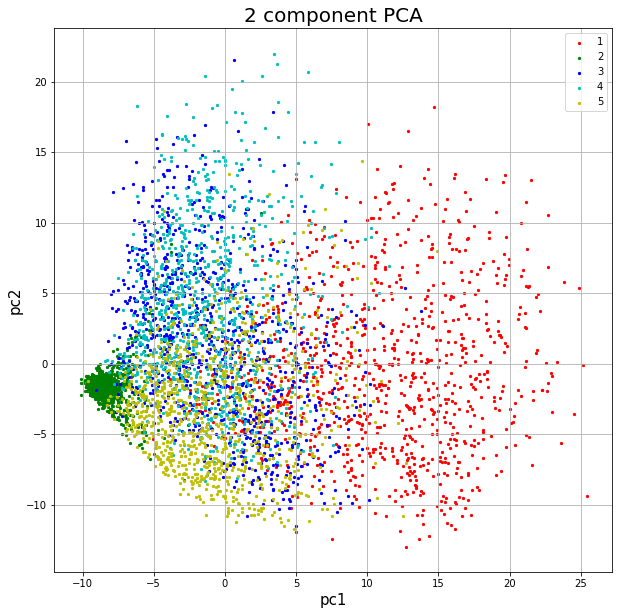

In [28]:
def pca(x_train,t_train):
    x_train = StandardScaler().fit_transform(x_train)    #returns transformed version of x_train
    cov_mat = np.cov(x_train.T)    #find covariance matrix with np library
    eigVectors,eigValues,V = np.linalg.svd(cov_mat, full_matrices = False)    #get eigenvalue, eigenvector
    eigVectors,V = svd_flip(eigVectors,V)    #correct the signs
    eigPairs = [(np.abs(eigValues[i]), eigVectors[:,i]) for i in range(len(eigValues))]   #pairing value to vectors
    eigPairs = sorted(eigPairs, key = lambda x: x[0], reverse=True)    #sorting pairs
    W = np.hstack((eigPairs[0][1].reshape(784,1), eigPairs[1][1].reshape(784,1)))    #reducing to feature space
    Y = x_train.dot(W)    #PCA projection with dot product of x and w
    principalDf = pd.DataFrame(data = Y, columns = ['pc1', 'pc2'])    #principal dataframe   
    ttrainDf = pd.DataFrame(data = t_train.values, columns = ['target'])
    finalDf = pd.concat([principalDf, ttrainDf], axis = 1)
    
    #plotting of figure
    fig = plt.figure(figsize = (10,10)) 
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('pc1', fontsize = 15)
    ax.set_ylabel('pc2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [1,2,3,4,5]     #target class
    colors = ['r', 'g', 'b', 'c', 'y']     #colours of graph
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 5)
    ax.legend(targets)
    ax.grid()

pca(xtrain,ttrain)  

/home/3nqing/.local/lib/python3.5/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


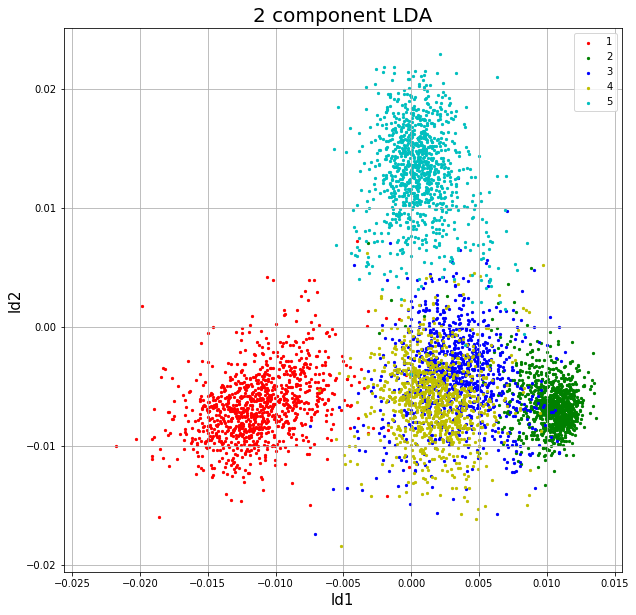

In [29]:
def lda(x_train, t_train):
    xtraindf = pd.DataFrame(x_train.values)
    ttraindf = pd.DataFrame(data = t_train.values, columns=['target'])
    classmean = np.zeros((5,784))    #mean for each class
    for i in range(1,6):
        datas = xtraindf[ttraindf['target'] == i]
        classmean[i-1] = datas.values.mean(axis=0)
    totalmean = xtraindf.values.mean(axis=0)
    # find SB
    SB = np.zeros((xtraindf.values.shape[1] , xtraindf.values.shape[1]))
    for i in range(1,6):
        nI = xtraindf[ttraindf['target']==i].shape[0]
        SB += nI * np.outer((classmean[i-1] - totalmean), (classmean[i-1] - totalmean))
    # find SW
    SW = np.zeros(SB.shape)
    for i in range(1,6):
        n = xtraindf[ttraindf['target']==i]
        m = n.values - np.expand_dims(classmean[i-1], axis=0)
        SW += np.dot(m.T,m)
    prod=np.dot(np.linalg.pinv(SW), SB)    #dot product of SW-inversed and SB
    # same operations as above
    eigValues, eigVectors = np.linalg.eig(prod)
    eigPairs = [(np.abs(eigValues[i]), eigVectors[:,i]) for i in range(len(eigValues))]    
    eigPairs = sorted(eigPairs, key = lambda x: x[0], reverse=True)
    W = np.hstack((eigPairs[0][1].reshape(784,1), eigPairs[1][1].reshape(784,1)))
    Y = x_train.dot(W)
    principalDf = pd.DataFrame(data = Y.values, columns = ['ld1', 'ld2'])
    finalDf = pd.concat([principalDf, ttraindf], axis = 1)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('ld1', fontsize = 15)
    ax.set_ylabel('ld2', fontsize = 15)
    ax.set_title('2 component LDA', fontsize = 20)
    targets = [1,2,3,4,5]
    colors = ['r', 'g', 'b', 'y', 'c']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'ld1'], finalDf.loc[indicesToKeep, 'ld2'], c = color, s = 5)
    ax.legend(targets)
    ax.grid()
    
lda(xtrain,ttrain)    

### Defining the kernels
Not much to explain here, just following the formulas. 

The linear kernel is the simplest kernel function. It is given by the inner product <x,y> plus an optional constant c

The rbf kernel follows the formula: k(x,y) = exp(-gamma*||x-y||^2), with gamma being a positive constant. Default value is set to a small value of 0.001 here to avoid potential underfitting (at the risk of overfitting).

The linear + rbf kernel is simply the linear kernel adding the rbf kernel.

In [45]:
def linear_kernel(x,y=None):
    if not np.any(np.equal(y, None)):
        return np.dot(x,y.T)
    else:
        return np.dot(x,x.T)
        
def rbf_kernel(x,y=None, gamma = 0.001):
    k = euclidean_distances(x,y, squared=True)
    k*= -gamma
    np.exp(k,k)
    return k
    
def linear_plus_rbf_kernel(x,y=None, gamma = 0.001):
    return linear_kernel(x,y)+rbf_kernel(x,y,gamma)

### Build Similarity Matrix
The similarity matrix is the similarity between each data points. Each entry of the matrix is computed with the chosen kernel from above.

In [46]:
def buildSimmilarityMatrix(dataIn,kernel,sigma=1.5):
    nData = dataIn.shape[0]
    result = np.matrix(np.full((nData,nData), 0, dtype=np.float))
    for i in range(0,nData):
        for j in range(0, nData):
            if(kernel=="rbf"):
                weight = rbf_kernel(dataIn[i, :], dataIn[j, :], sigma=sigma)
            if(kernel=="linear"):
                weight = linear_kernel(dataIn[i, :], dataIn[j, :], sigma=sigma)
            if(kernel=="linearplusrbf"):
                weight = linear_plus_rbf_kernel(dataIn[i, :], dataIn[j, :], sigma=sigma)
            result[i,j] = weight
    return result

### Unnormalized Laplacian
We will first compute the un-normalized laplacian from the similarity matrix. We will then build a degree matrix, which is a diagonal matrix where each entry is the summation of the respective row of the simmilarity matrix. After that, we may obtain the Laplacian Matrix, which is the degree matrix subtracting away the simmilarity matrix.

In [47]:
def buildDegreeMatrix(similarityMatrix):
    diag = np.array(similarityMatrix.sum(axis=1)).ravel()
    result = np.diag(diag)
    return result
    
def unnormalizedLaplacian(simMatrix, degMatrix):
    result = degMatrix - simMatrix
    return result

The normalized graph Laplacian is the matrix

N = (D^(-1/2))L(D^(-1/2)), where L is the unnormalized Laplacian and D is the diagonal matrix of node degrees.

In [50]:
def normalizedLaplacian(similarityMatrix,degMatrix):
    diag = np.array(similarityMatrix.sum(axis=1)).ravel()
    diags_sqrt = 1.0/scipy.sqrt(diag)
    diags_sqrt[scipy.isinf(diags_sqrt)] = 0
    DH = scipy.sparse.spdiags(diags_sqrt, [0], m, n, format='csr')
    L=unnormalizedLaplacian(similarityMatrix,degMatrix)
    return DH.dot(L.dot(DH))

### Faces
Now we will use PCA to produce the eigenfaces and then use random module to randomly select 10 of the reconstructed faces from the 25 faces.

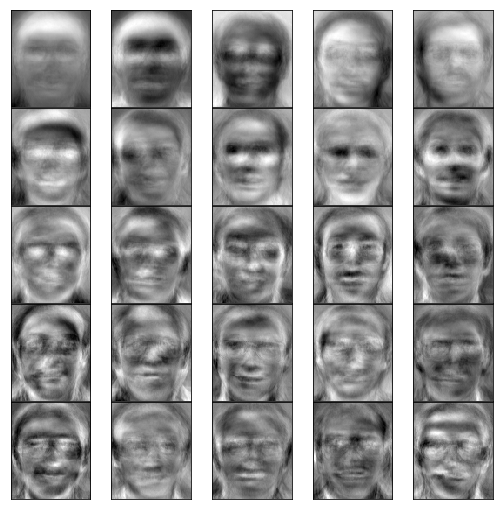

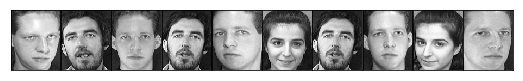

In [61]:
def faces():
    faces = pd.DataFrame([])     #reading the data
    for path in iglob('att_faces/*/*.pgm'):
        img=imageio.imread(path)
        face = pd.Series(img.flatten(),name=path)
        faces = faces.append(face)
    faces_pca = pca(faces.data,faces.label)
    fig, axes = plt.subplots(5,5, figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
    for i, ax in enumerate(axes.flat):
        ax.imshow(faces_pca.components_[i].reshape(112,92),cmap='gray')
    components = faces_pca.transform(faces)
    projected = faces_pca.inverse_transform(components)
    fig, axes = plt.subplots(1,10, figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
    for i, ax in enumerate(axes.flat):
        i=random.randint(0,26)
        ax.imshow(projected[i].reshape(112,92),cmap='gray')
faces()